# 1. Загрузка данных

In [ ]:
import os
import re
import pandas as pd
import numpy as np

In [ ]:
!wget "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
!unzip ml-latest-small.zip

--2024-06-20 06:35:08--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  5.55MB/s    in 0.2s    

2024-06-20 06:35:08 (5.55 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
folder_name = 'ml-latest-small'

df_links = pd.read_csv(os.path.join(folder_name, 'links.csv'))
df_movies = pd.read_csv(os.path.join(folder_name, 'movies.csv'))
df_ratings = pd.read_csv(os.path.join(folder_name, 'ratings.csv'))
df_tags = pd.read_csv(os.path.join(folder_name, 'tags.csv'))

In [ ]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# 2. Подготовка данных

## ratings

Статистка по рейтингу для каждого фильма:

In [ ]:
df_ratings_by_film = df_ratings.groupby('movieId').agg(
    rating_mean=('rating', 'mean'),
    rating_var=('rating', 'var'),
    rating_mediam=('rating', 'median'),
    rating_count=('rating', 'count')).reset_index()
df_ratings_by_film.head()

,movieId,rating_mean,rating_var,rating_mediam,rating_count
0,1,3.920930,0.696990,4.0,215
1,2,3.431818,0.777419,3.5,110
2,3,3.259615,1.112651,3.0,52
3,4,2.357143,0.726190,3.0,7
4,5,3.071429,0.822917,3.0,49


In [ ]:
df_ratings_by_film['rating_var'] = df_ratings_by_film['rating_var'].fillna(0)

In [ ]:
df_movies_tags_ratings = df_ratings.join(df_ratings_by_film.set_index('movieId'), on='movieId')
df_movies_tags_ratings.head()

,userId,movieId,rating,timestamp,rating_mean,rating_var,rating_mediam,rating_count
0,1,1,4.0,964982703,3.920930,0.696990,4.0,215
1,1,3,4.0,964981247,3.259615,1.112651,3.0,52
2,1,6,4.0,964982224,3.946078,0.667856,4.0,102
3,1,47,5.0,964983815,3.975369,0.850875,4.0,203
4,1,50,5.0,964982931,4.237745,0.641475,4.5,204


In [ ]:
df_ratings.shape, df_movies_tags_ratings.shape

((100836, 4), (100836, 8))

ratings + movies:

In [ ]:
df_movies_tags_ratings = df_movies_tags_ratings.merge(df_movies, on='movieId')
df_movies_tags_ratings.head()

,userId,movieId,rating,timestamp,rating_mean,rating_var,rating_mediam,rating_count,title,genres
0,1,1,4.0,964982703,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
df_movies_tags_ratings.shape

(100836, 10)

ratings + movies + tags:

In [ ]:
df_movies_tags_ratings = df_movies_tags_ratings.merge(
    df_tags.groupby('movieId').agg({'tag': '|'.join}),
    on='movieId')
df_movies_tags_ratings.head()

,userId,movieId,rating,timestamp,rating_mean,rating_var,rating_mediam,rating_count,title,genres,tag
0,1,1,4.0,964982703,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar|pixar|fun
1,5,1,4.0,847434962,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar|pixar|fun
2,7,1,4.5,1106635946,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar|pixar|fun
3,15,1,2.5,1510577970,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar|pixar|fun
4,17,1,4.5,1305696483,3.92093,0.69699,4.0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar|pixar|fun


In [ ]:
df_movies_tags_ratings.shape

(48287, 11)

## genres

Уникальные жанры:

(поиск символов, которые, необходимо удалить для tf-idf)

In [ ]:
def get_unique(values):
  unique_items = []
  for i in [i.split('|') for i in values]:
    unique_items.extend(i)

  return set(unique_items)

In [ ]:
get_unique(df_movies.genres)

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [ ]:
def change(item):
  item = re.sub(r"[-()\s\.]", "", item)
  item = ' '.join(item.split('|')).lower()
  return item

In [ ]:
genres = df_movies_tags_ratings['genres'].apply(change).to_list()
print(f'{len(genres)} ({len(np.unique(genres))} уникальных строк)\n')
np.unique(genres)[:5]

48287 (370 уникальных строк)



array(['action adventure', 'action adventure animation children comedy',
       'action adventure animation children comedy fantasy',
       'action adventure animation children comedy scifi',
       'action adventure animation children fantasy scifi'], dtype='<U57')

In [ ]:
df_movies_tags_ratings['genres'] = genres
df_movies_tags_ratings.head()

,userId,movieId,rating,timestamp,rating_mean,rating_var,rating_mediam,rating_count,title,genres,tag
0,1,1,4.0,964982703,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar|pixar|fun
1,5,1,4.0,847434962,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar|pixar|fun
2,7,1,4.5,1106635946,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar|pixar|fun
3,15,1,2.5,1510577970,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar|pixar|fun
4,17,1,4.5,1305696483,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar|pixar|fun


## tags

Поиск символов, которые, необходимо удалить для tf-idf.

В основном это относительно уникальные теги (встречаются 1-4 раза). Точки, тире и скобки можно удалить по аналогии с жанрами.

In [ ]:
t = [re.sub(r'[\s\w]', '', i) for i in df_tags.tag.values]
np.unique(t)
pd.Series(t).value_counts()

         3522
-          96
.          15
:          10
()         10
..          8
'           4
/           3
!           3
&           3
(-)         2
--          2
...!        1
--()        1
()/()       1
""          1
:/          1
Name: count, dtype: int64

In [ ]:
tags = df_movies_tags_ratings['tag'].apply(change).to_list()
print(f'{len(tags)} ({len(np.unique(tags))} уникальных строк)\n')
np.unique(tags)[:5]

48287 (1015 уникальных строк)



array(['"artsy" atmospheric gritty hallucinatory surreal visuallystunning',
       '06oscarnominatedbestmovieanimation aardman', '1900s', '1920s',
       '1920s gangsters'], dtype='<U2067')

In [ ]:
df_movies_tags_ratings['tag'] = tags
df_movies_tags_ratings.head()

,userId,movieId,rating,timestamp,rating_mean,rating_var,rating_mediam,rating_count,title,genres,tag
0,1,1,4.0,964982703,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun
1,5,1,4.0,847434962,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun
2,7,1,4.5,1106635946,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun
3,15,1,2.5,1510577970,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun
4,17,1,4.5,1305696483,3.92093,0.69699,4.0,215,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun


# 3. TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def get_df_tfidf(values):
  tfidf = TfidfVectorizer()
  X_train_tfidf = tfidf.fit_transform(values)

  return pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
df_tfidf_genres = get_df_tfidf(df_movies_tags_ratings.genres.values)
df_tfidf_genres.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,0.0,0.360893,0.543437,0.506294,0.310618,0.0,0.0,0.0,0.470759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.360893,0.543437,0.506294,0.310618,0.0,0.0,0.0,0.470759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.360893,0.543437,0.506294,0.310618,0.0,0.0,0.0,0.470759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.360893,0.543437,0.506294,0.310618,0.0,0.0,0.0,0.470759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.360893,0.543437,0.506294,0.310618,0.0,0.0,0.0,0.470759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_tfidf_tags = get_df_tfidf(df_movies_tags_ratings.tag.values)
df_tfidf_tags.head()

,06oscarnominatedbestmovieanimation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001like,2danimation,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_tfidf_genres.shape, df_tfidf_tags.shape

((48287, 20), (48287, 1461))

In [ ]:
df_tfidf = pd.concat([df_movies_tags_ratings, df_tfidf_genres], axis=1)
df_tfidf = pd.concat([df_tfidf, df_tfidf_tags], axis=1)
df_tfidf = df_tfidf.drop(['userId', 'movieId', 'title', 'timestamp', 'genres', 'tag'], axis=1)
df_tfidf.head()

,rating,rating_mean,rating_var,rating_mediam,rating_count,action,adventure,animation,children,comedy,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,4.0,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.5,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.5,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.5,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_tfidf.shape

(48287, 1486)

# 4. LinearRegression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X = df_tfidf.drop(['rating'], axis=1)
X.head()

,rating_mean,rating_var,rating_mediam,rating_count,action,adventure,animation,children,comedy,crime,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.92093,0.69699,4.0,215,0.0,0.360893,0.543437,0.506294,0.310618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

X = MinMaxScaler().fit(X).transform(X)

In [ ]:
y = df_tfidf['rating']
y.head()

0    4.0
1    4.0
2    4.5
3    2.5
4    4.5
Name: rating, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model = LinearRegression()#normalize=True)
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_test_pred = np.round(model.predict(X_test) * 2) / 2
y_test_pred = np.round(y_test_pred, 1)

print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))}')
print(f'R2: {metrics.r2_score(y_test, y_test_pred)}')

RMSE: 788781036.6144862
R2: -6.620384863061492e+17


In [ ]:
pd.Series(y_test_pred).value_counts()

 4.000000e+00    5044
 3.500000e+00    3042
 3.000000e+00     873
 4.500000e+00     458
 2.500000e+00     178
 2.000000e+00      35
 5.000000e+00       9
 1.180093e+10       4
 6.302191e+09       2
 6.986509e+09       2
-4.235521e+10       2
 1.500000e+00       2
 1.000000e+00       1
 8.703123e+09       1
 6.283797e+08       1
-1.117237e+10       1
 5.642750e+08       1
 1.186184e+09       1
-3.852597e+10       1
Name: count, dtype: int64

MemoryError: Unable to allocate 7.84 PiB for an array with shape (1103050230590258,) and data type float64

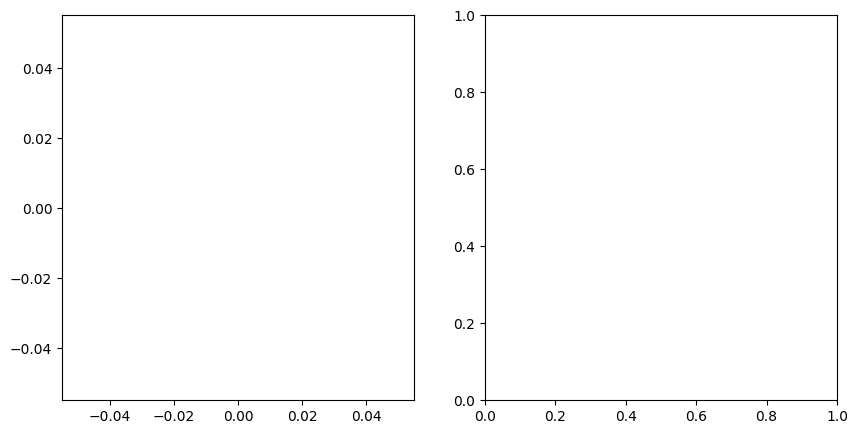

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(y_test_pred, ax=ax[0], label='y_pred')
sns.histplot(y_test, ax=ax[1], label='y_test')

plt.show()

<Axes: xlabel='rating', ylabel='Count'>

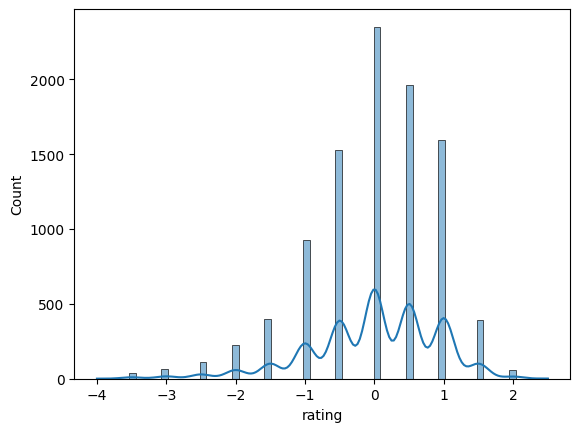

In [ ]:
sns.histplot((y_test-y_test_pred), kde=True)

RMSE равна примерно 0.92, то есть среднеквадратичная разница между исинным и предсказанным значениями составляет почти 1 балл.

Значение R2 при этом очень низкое, модель совсем неэффективна.

Как предположение - в итоговом датафрейме df_tfidf много жанров и тегов (особенно тегов), которые встречаются всего несколько раз.

Для эксперимента можно обучить модель только на признаках для рейтинга:

In [ ]:
X = df_tfidf[['rating_var', 'rating_mean', 'rating_mediam', 'rating_count']]
y = df_tfidf['rating']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_test_pred = np.round(model.predict(X_test) * 2) / 2

print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))}')
print(f'R2: {metrics.r2_score(y_test, y_test_pred)}')

RMSE: 0.8985331227193195
R2: 0.1409103292087136


Значение R2 немного увеличилось, но, в любом случае, модель предсказывает хуже чем модель простого среднего.